In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
data_path = "/home/user/data_directory/MIME_sim_data/no_epistasis"

In [88]:
# read in ground_truth_kds.txt as np array
ground_truth = np.loadtxt(data_path+'/prot1/single_kds.txt')
print(ground_truth.shape)

(300,)


In [89]:
def get_inferred_Kds(path : str):
    """
    Get inferred Kds from PositionWiseKdEstimates.csv file
    """
    df = pd.read_csv(path, sep='\t')
    median_mut_C = df['median mut C'].values
    median_mut_G = df['median mut G'].values
    median_mut_U = df['median mut U'].values
    median_Kds = np.vstack((median_mut_C, median_mut_G, median_mut_U)).T.flatten()
    return median_Kds

In [90]:
prot_01 =  get_inferred_Kds(data_path + '/prot0.1/results/PositionWiseKdEstimates.csv')
prot_1 = get_inferred_Kds(data_path + '/prot1/results/PositionWiseKdEstimates.csv')
prot_10 = get_inferred_Kds(data_path + '/prot10/results/PositionWiseKdEstimates.csv')

print(prot_01.shape)
print(prot_1.shape)
print(prot_10.shape)

(300,)
(300,)
(300,)


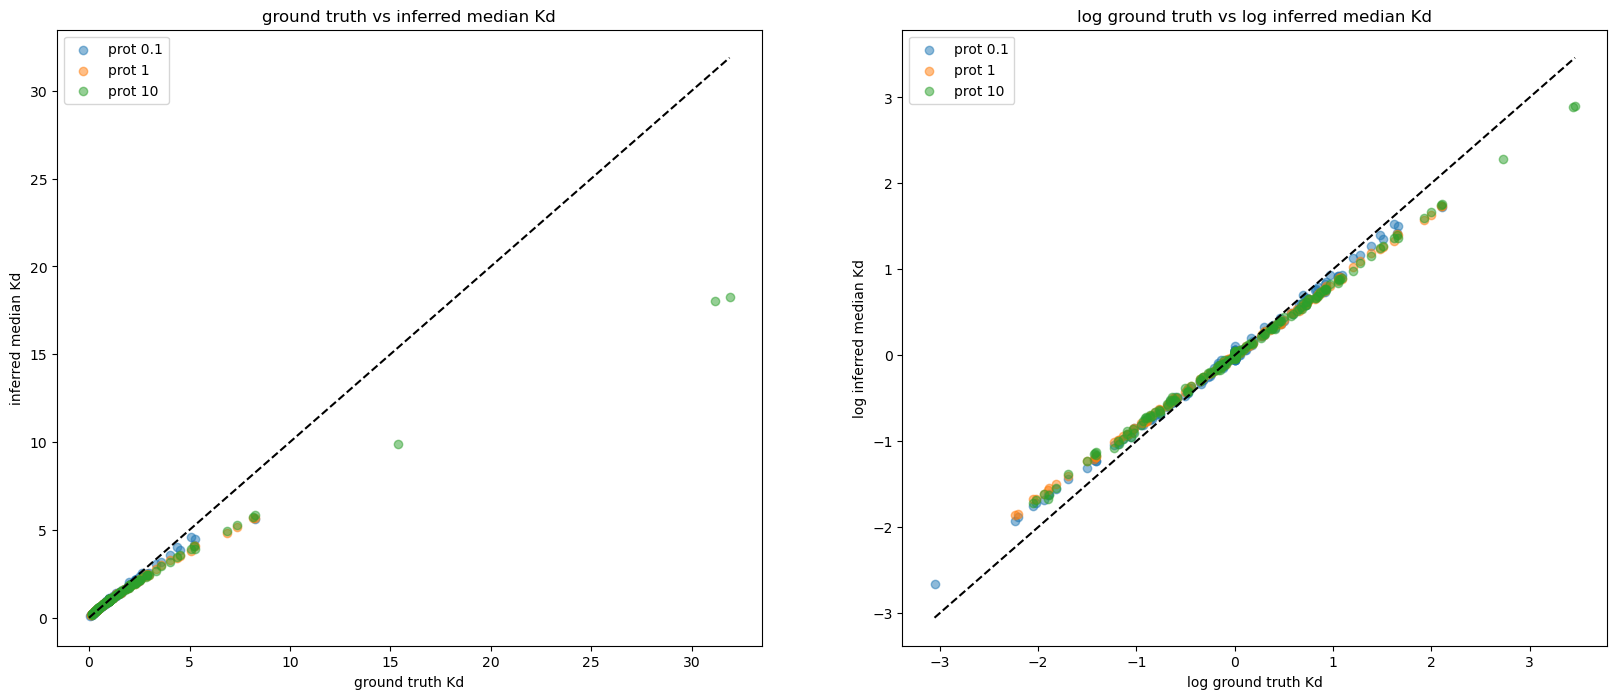

In [91]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# plot ground truth vs inferred median Kds of each protein concentration
ax1.scatter(ground_truth, prot_01, label='prot 0.1', alpha=0.5)
ax1.scatter(ground_truth, prot_1, label='prot 1', alpha=0.5)
ax1.scatter(ground_truth, prot_10, label='prot 10', alpha=0.5)
ax1.set_xlabel('ground truth Kd')
ax1.set_ylabel('inferred median Kd')
ax1.set_title('ground truth vs inferred median Kd')
ax1.legend()
x = np.linspace(0, np.max(ground_truth), 100)
y = x
ax1.plot(x, y, color='black', linestyle='--')

# plot log ground truth vs log inferred median Kds of each protein concentration
ax2.scatter(np.log(ground_truth), np.log(prot_01), label='prot 0.1', alpha=0.5)
ax2.scatter(np.log(ground_truth), np.log(prot_1), label='prot 1', alpha=0.5)
ax2.scatter(np.log(ground_truth), np.log(prot_10), label='prot 10', alpha=0.5)
ax2.set_xlabel('log ground truth Kd')
ax2.set_ylabel('log inferred median Kd')
ax2.set_title('log ground truth vs log inferred median Kd')
ax2.legend()
x = np.linspace(np.min(np.log(ground_truth)), np.max(np.log(ground_truth)), 100)
y = x
ax2.plot(x, y, color='black', linestyle='--')

plt.show()

In [92]:
# define function to compute the expected Kds
def compute_expected_Kds(path_to_unbound_counts : str, path_to_inferred_Kds : str):
    """
    Compute the expected Kds
    """
    # load unbound counts
    unbound_counts = np.loadtxt(path_to_unbound_counts, skiprows=1, dtype=int)
    # remove first and second column
    unbound_counts = unbound_counts[:, 1:]
    # subtract 0.45 percent from column 3,4 and 5
    # unbound_counts[:, 0] = unbound_counts[:, 0] - unbound_counts[:, 0]*0.0045
    unbound_counts[:, 1] = unbound_counts[:, 1] - unbound_counts[:, 1]*0.0045
    unbound_counts[:, 2] = unbound_counts[:, 2] - unbound_counts[:, 2]*0.0045
    unbound_counts[:, 3] = unbound_counts[:, 3] - unbound_counts[:, 3]*0.0045
    # compute proportion of unbound counts
    unbound_counts = unbound_counts / unbound_counts.sum(axis=1)[:, None]
    # remove first column
    # unbound_counts = unbound_counts[:, 1:]

    # load inferred Kds
    df = pd.read_csv(path_to_inferred_Kds, sep='\t')
    # replace nan with 1
    df = df.fillna(1)

    median_mut_C = df['median mut C'].values
    median_mut_G = df['median mut G'].values
    median_mut_U = df['median mut U'].values

    # stack median_mut_C, median_mut_G, median_mut_U as columns
    median_Kds = np.vstack((median_mut_C, median_mut_G, median_mut_U)).T
    # add a column of 1s to the left of median_Kds
    median_Kds = np.hstack((np.ones((median_Kds.shape[0], 1)), median_Kds))
    # elemntwise product of median_Kds and unbound_counts
    expected_mut_Kds = np.log2(median_Kds) * unbound_counts

    # compute the average Kd as product of the expected_mut_Kds per row
    weighted_Kds = np.zeros(median_Kds.shape[0])
    for i in range(median_Kds.shape[0]):
        weighted_Kds[i] = np.sum(expected_mut_Kds[i])
    weighted_Kds = np.exp2(weighted_Kds)

    print(weighted_Kds.shape)
    
    expected_sequence_Kd = np.prod(weighted_Kds)

    print('expected sequence Kd: ', expected_sequence_Kd)
    print(weighted_Kds.min(), weighted_Kds.mean(), weighted_Kds.max())

    # repeat each weighted Kd 3 times
    weighted_Kds = np.repeat(weighted_Kds, 3)

    return weighted_Kds, expected_sequence_Kd

In [93]:
inferred_Kds_prot_01_01 = get_inferred_Kds(data_path + '/secondFromProt0.1/prot0.1/results/PositionWiseKdEstimates.csv')
inferred_Kds_prot_01_1 = get_inferred_Kds(data_path + '/secondFromProt0.1/prot1/results/PositionWiseKdEstimates.csv')
inferred_Kds_prot_01_10 = get_inferred_Kds(data_path + '/secondFromProt0.1/prot10/results/PositionWiseKdEstimates.csv')

inferred_Kds_prot_1_01 = get_inferred_Kds(data_path + '/secondFromProt1/prot0.1/results/PositionWiseKdEstimates.csv')
inferred_Kds_prot_1_1 = get_inferred_Kds(data_path + '/secondFromProt1/prot1/results/PositionWiseKdEstimates.csv')
inferred_Kds_prot_1_10 = get_inferred_Kds(data_path + '/secondFromProt1/prot10/results/PositionWiseKdEstimates.csv')

inferred_Kds_prot_10_01 = get_inferred_Kds(data_path + '/secondFromProt10/prot0.1/results/PositionWiseKdEstimates.csv')
inferred_Kds_prot_10_1 = get_inferred_Kds(data_path + '/secondFromProt10/prot1/results/PositionWiseKdEstimates.csv')
inferred_Kds_prot_10_10 = get_inferred_Kds(data_path + '/secondFromProt10/prot10/results/PositionWiseKdEstimates.csv')

print(inferred_Kds_prot_01_01.shape)
print(inferred_Kds_prot_01_1.shape)
print(inferred_Kds_prot_01_10.shape)

print(inferred_Kds_prot_1_01.shape)
print(inferred_Kds_prot_1_1.shape)
print(inferred_Kds_prot_1_10.shape)

print(inferred_Kds_prot_10_01.shape)
print(inferred_Kds_prot_10_1.shape)
print(inferred_Kds_prot_10_10.shape)

(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)


In [94]:
expected_Kds_prot_01, expected_sequence_Kds_prot_01 = compute_expected_Kds(data_path + '/prot0.1/1d/4.txt', data_path + '/prot0.1/results/PositionWiseKdEstimates.csv')
expected_Kds_prot_1, expected_sequence_Kds_prot_1= compute_expected_Kds(data_path + '/prot0.1/1d/4.txt', data_path + '/prot1/results/PositionWiseKdEstimates.csv')
expected_Kds_prot_10, expected_sequence_Kds_prot_10 = compute_expected_Kds(data_path + '/prot0.1/1d/4.txt', data_path + '/prot10/results/PositionWiseKdEstimates.csv')

print(expected_Kds_prot_01.shape)
print(expected_Kds_prot_1.shape)
print(expected_Kds_prot_10.shape)

(100,)
expected sequence Kd:  0.9562202938958159
0.9759278251718755 0.9995866417255964 1.024070345574305
(100,)
expected sequence Kd:  1.013151216844638
0.9768770143471702 1.0001661965440458 1.0237727168881783
(100,)
expected sequence Kd:  1.1175305435245835
0.9788047884867933 1.001160485547631 1.041403470731363
(300,)
(300,)
(300,)


In [95]:
def correct_Kds_per_mutation(path_inferred_kds : str, path_counts : str):
    # load unbound counts
    unbound_counts = np.loadtxt(path_counts+'8.txt', skiprows=1, dtype=int)
    # load bound counts
    bound_counts = np.loadtxt(path_counts+'7.txt', skiprows=1, dtype=int)
    counts = bound_counts + unbound_counts
    # remove first column (pos)
    counts = counts[:, 1:]
    # subtract 0.45 percent from all mutation columns
    counts[:, 1] = counts[:, 1] - counts[:, 1]*0.0045
    counts[:, 2] = counts[:, 2] - counts[:, 2]*0.0045
    counts[:, 3] = counts[:, 3] - counts[:, 3]*0.0045
    # compute proportion of unbound counts
    counts = counts / counts.sum(axis=1)[:, None]
    # remove first column (wildtype unbound counts)
    counts = counts[:, 1:]

    # load inferred Kds
    df = pd.read_csv(path_inferred_kds, sep='\t')
    # replace nan with 1
    # df = df.fillna(1)

    median_mut_C = df['median mut C'].values
    median_mut_G = df['median mut G'].values
    median_mut_U = df['median mut U'].values

    # stack median_mut_C, median_mut_G, median_mut_U as columns
    median_Kds = np.vstack((median_mut_C, median_mut_G, median_mut_U)).T

    counts = counts.flatten()
    median_Kds = median_Kds.flatten()

    counts_no_nan = counts[~np.isnan(median_Kds)]
    median_Kds_no_nan = median_Kds[~np.isnan(median_Kds)]
    
    # compute correceted Kds
    corrected_Kds = np.zeros(median_Kds.shape[0])
    for i in range(median_Kds.shape[0]):
        # skip if median_Kds[i] is nan
        if np.isnan(median_Kds[i]):
            corrected_Kds[i] = np.nan
            continue
        corrected_Kds[i] = np.exp((np.log(median_Kds[i]) + np.sum(counts_no_nan*np.log(median_Kds_no_nan/np.repeat(median_Kds[i],median_Kds_no_nan.shape[0]))))/(1-np.sum(counts_no_nan)))

    # stack rows of corrected_Kds to get a 1D array
    corrected_Kds = corrected_Kds.flatten()

    return corrected_Kds



In [96]:
corrected_Kds_prot_01_01 = correct_Kds_per_mutation(data_path + '/secondFromProt0.1/prot0.1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt0.1/prot0.1/1d/')
corrected_Kds_prot_01_1 = correct_Kds_per_mutation(data_path + '/secondFromProt0.1/prot1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt0.1/prot1/1d/')
corrected_Kds_prot_01_10 = correct_Kds_per_mutation(data_path + '/secondFromProt0.1/prot10/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt0.1/prot10/1d/')

corrected_Kds_prot_1_01 = correct_Kds_per_mutation(data_path + '/secondFromProt1/prot0.1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt1/prot0.1/1d/')
corrected_Kds_prot_1_1 = correct_Kds_per_mutation(data_path + '/secondFromProt1/prot1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt1/prot1/1d/')
corrected_Kds_prot_1_10 = correct_Kds_per_mutation(data_path + '/secondFromProt1/prot10/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt1/prot10/1d/')

corrected_Kds_prot_10_01 = correct_Kds_per_mutation(data_path + '/secondFromProt10/prot0.1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt10/prot0.1/1d/')
corrected_Kds_prot_10_1 = correct_Kds_per_mutation(data_path + '/secondFromProt10/prot1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt10/prot1/1d/')
corrected_Kds_prot_10_10 = correct_Kds_per_mutation(data_path + '/secondFromProt10/prot10/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt10/prot10/1d/')

print(corrected_Kds_prot_01_01.shape)
print(corrected_Kds_prot_01_01[:10])
print(corrected_Kds_prot_01_1.shape)
print(corrected_Kds_prot_01_10.shape)

print(corrected_Kds_prot_1_01.shape)
print(corrected_Kds_prot_1_1.shape)
print(corrected_Kds_prot_1_10.shape)

print(corrected_Kds_prot_10_01.shape)
print(corrected_Kds_prot_10_1.shape)
print(corrected_Kds_prot_10_10.shape)

(300,)
[0.84337401 0.8062062  1.18601336 0.79329202 0.79436042        nan
 0.58291649 0.74608094 1.17801871 1.72412248]
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)


In [97]:
def comparison_plot(ground_truth_Kds, inferred_Kds_1, inferred_Kds_2, inferred_Kds_3, corrected_Kds_1, corrected_Kds_2, corrected_Kds_3, title : str):
    """
    Plot the comparison of ground truth vs inferred Kds and corrected Kds
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # plot ground truth vs inferred median Kds of each protein concentration
    ax1.scatter(ground_truth_Kds, inferred_Kds_1, label='prot 0.1', alpha=0.5)
    ax1.scatter(ground_truth_Kds, inferred_Kds_2, label='prot 1', alpha=0.5)
    ax1.scatter(ground_truth_Kds, inferred_Kds_3, label='prot 10', alpha=0.5)
    ax1.set_xlabel('ground truth Kd')
    ax1.set_ylabel('inferred median Kd')
    ax1.legend()
    x = np.linspace(0, np.max(ground_truth_Kds), 100)
    y = x
    ax1.plot(x, y, color='black', linestyle='--')

    # plot log ground truth vs log inferred median Kds of each protein concentration
    ax2.scatter(np.log(ground_truth_Kds), np.log(inferred_Kds_1), label='prot 0.1', alpha=0.5)
    ax2.scatter(np.log(ground_truth_Kds), np.log(inferred_Kds_2), label='prot 1', alpha=0.5)
    ax2.scatter(np.log(ground_truth_Kds), np.log(inferred_Kds_3), label='prot 10', alpha=0.5)
    ax2.set_xlabel('log ground truth Kd')
    ax2.set_ylabel('log inferred median Kd')
    ax2.legend()
    x = np.linspace(np.min(np.log(ground_truth_Kds)), np.max(np.log(ground_truth_Kds)), 100)
    y = x
    ax2.plot(x, y, color='black', linestyle='--')

    # set overall title
    fig.suptitle(title)

    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # plot ground truth vs corrected median Kds of each protein concentration
    ax1.scatter(ground_truth_Kds, corrected_Kds_1, label='prot 0.1', alpha=0.5)
    ax1.scatter(ground_truth_Kds, corrected_Kds_2, label='prot 1', alpha=0.5)
    ax1.scatter(ground_truth_Kds, corrected_Kds_3, label='prot 10', alpha=0.5)
    ax1.set_xlabel('ground truth Kd')
    ax1.set_ylabel('corrected median Kd')
    ax1.legend()
    x = np.linspace(0, np.max(ground_truth_Kds), 100)
    y = x
    ax1.plot(x, y, color='black', linestyle='--')

    # plot log ground truth vs log corrected median Kds of each protein concentration
    ax2.scatter(np.log(ground_truth_Kds), np.log(corrected_Kds_1), label='prot 0.1', alpha=0.5)
    ax2.scatter(np.log(ground_truth_Kds), np.log(corrected_Kds_2), label='prot 1', alpha=0.5)
    ax2.scatter(np.log(ground_truth_Kds), np.log(corrected_Kds_3), label='prot 10', alpha=0.5)
    ax2.set_xlabel('log ground truth Kd')
    ax2.set_ylabel('log corrected median Kd')
    ax2.legend()
    x = np.linspace(np.min(np.log(ground_truth_Kds)), np.max(np.log(ground_truth_Kds)), 100)
    y = x
    ax2.plot(x, y, color='black', linestyle='--')

    # set overall title
    fig.suptitle(title + ', corrected')

    plt.show()
    
    # print squared error for inferred Kds where inferred Kds are not nan
    print('squared error for inferred Kds')
    print(np.round(np.nanmean(np.square(ground_truth_Kds - inferred_Kds_1)), 3))
    print(np.round(np.nanmean(np.square(ground_truth_Kds - inferred_Kds_2)), 3))
    print(np.round(np.nanmean(np.square(ground_truth_Kds - inferred_Kds_3)), 3))

    # print squared error for corrected Kds where corrected Kds are not nan
    print('squared error for corrected Kds')
    print(np.round(np.nanmean(np.square(ground_truth_Kds - corrected_Kds_1)), 3))
    print(np.round(np.nanmean(np.square(ground_truth_Kds - corrected_Kds_2)), 3))
    print(np.round(np.nanmean(np.square(ground_truth_Kds - corrected_Kds_3)), 3))

    # print the difference between the mean of the inferred Kds and the mean of the corrected Kds
    print('difference between squared error for inferred Kds and corrected Kds')
    print(np.round(np.nanmean(np.square(ground_truth_Kds - inferred_Kds_1)) - np.nanmean(np.square(ground_truth_Kds - corrected_Kds_1)), 3))
    print(np.round(np.nanmean(np.square(ground_truth_Kds - inferred_Kds_2)) - np.nanmean(np.square(ground_truth_Kds - corrected_Kds_2)), 3))
    print(np.round(np.nanmean(np.square(ground_truth_Kds - inferred_Kds_3)) - np.nanmean(np.square(ground_truth_Kds - corrected_Kds_3)), 3))

    # plot the mean of the inferred Kds and corrected Kds
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # plot ground truth vs inferred median Kds of each protein concentration
    ax1.scatter(ground_truth_Kds, np.mean([inferred_Kds_1, inferred_Kds_2, inferred_Kds_3], axis=0), label='inferred', alpha=0.5)
    ax1.scatter(ground_truth_Kds, np.mean([corrected_Kds_1, corrected_Kds_2, corrected_Kds_3], axis=0), label='corrected', alpha=0.5)
    ax1.set_xlabel('ground truth Kd')
    ax1.set_ylabel('mean Kd')
    ax1.legend()
    x = np.linspace(0, np.max(ground_truth_Kds), 100)
    y = x
    ax1.plot(x, y, color='black', linestyle='--')

    # plot log ground truth vs log inferred median Kds of each protein concentration
    ax2.scatter(np.log(ground_truth_Kds), np.log(np.mean([inferred_Kds_1, inferred_Kds_2, inferred_Kds_3], axis=0)), label='inferred', alpha=0.5)
    ax2.scatter(np.log(ground_truth_Kds), np.log(np.mean([corrected_Kds_1, corrected_Kds_2, corrected_Kds_3], axis=0)), label='corrected', alpha=0.5)
    ax2.set_xlabel('log ground truth Kd')
    ax2.set_ylabel('log mean Kd')
    ax2.legend()
    x = np.linspace(np.min(np.log(ground_truth_Kds)), np.max(np.log(ground_truth_Kds)), 100)
    y = x
    ax2.plot(x, y, color='black', linestyle='--')

    # set overall title
    fig.suptitle(title + ', mean')

    plt.show()

    # print the squared error for the mean of the inferred Kds and the mean of the corrected Kds
    print('squared error for mean of inferred Kds and corrected Kds')
    print(np.round(np.nanmean(np.square(ground_truth_Kds - np.mean([inferred_Kds_1, inferred_Kds_2, inferred_Kds_3], axis=0))), 3))
    print(np.round(np.nanmean(np.square(ground_truth_Kds - np.mean([corrected_Kds_1, corrected_Kds_2, corrected_Kds_3], axis=0))), 3))

    # print the difference between the mean of the inferred Kds and the mean of the corrected Kds
    print('difference between squared error for mean of inferred Kds and corrected Kds')
    print(np.round(np.nanmean(np.square(ground_truth_Kds - np.mean([inferred_Kds_1, inferred_Kds_2, inferred_Kds_3], axis=0))) - np.nanmean(np.square(ground_truth_Kds - np.mean([corrected_Kds_1, corrected_Kds_2, corrected_Kds_3], axis=0))),3))

    
          
    


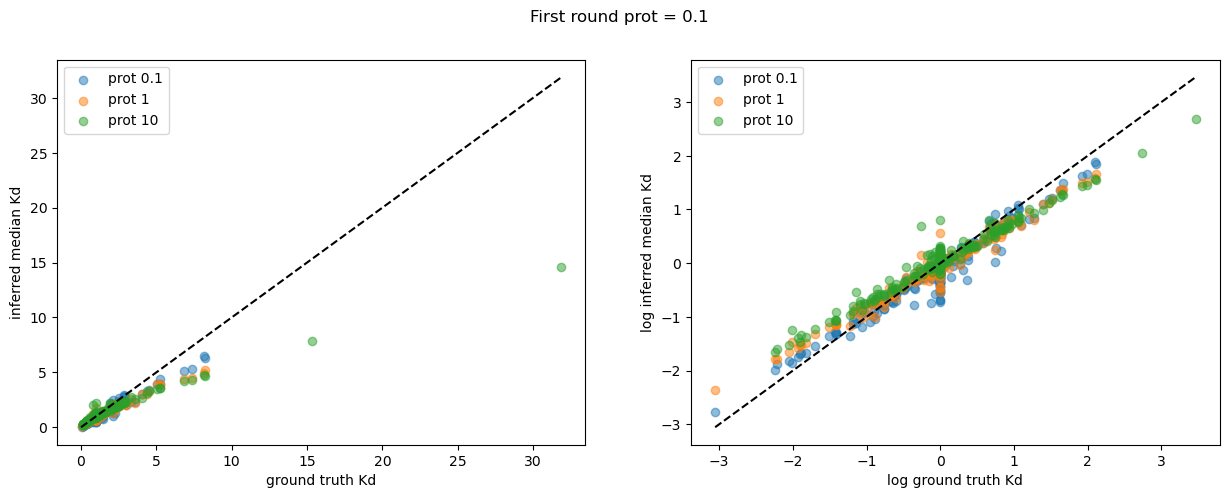

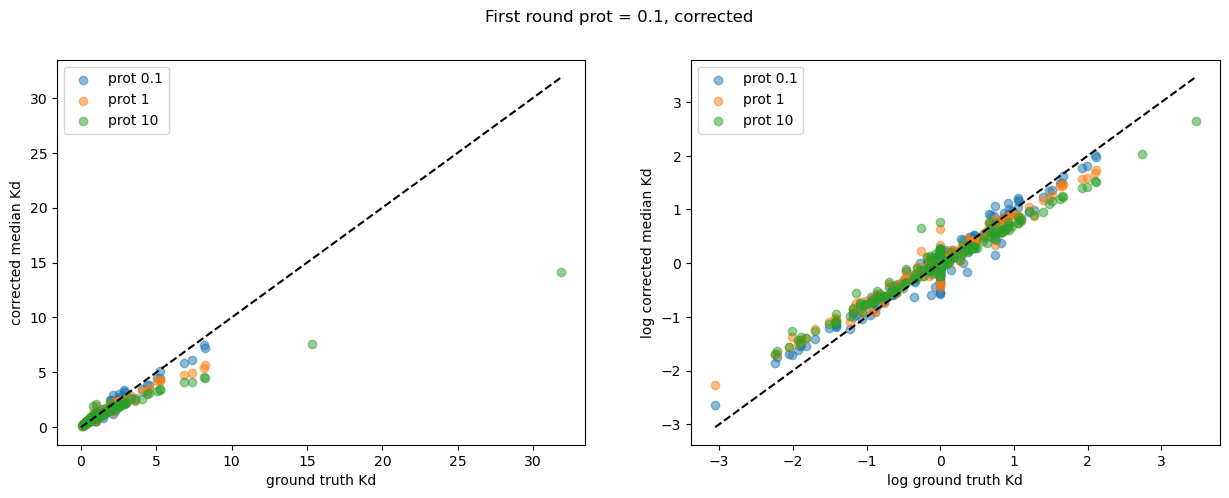

squared error for inferred Kds
0.121
0.189
1.42
squared error for corrected Kds
0.057
0.131
1.514
difference between squared error for inferred Kds and corrected Kds
0.064
0.058
-0.094


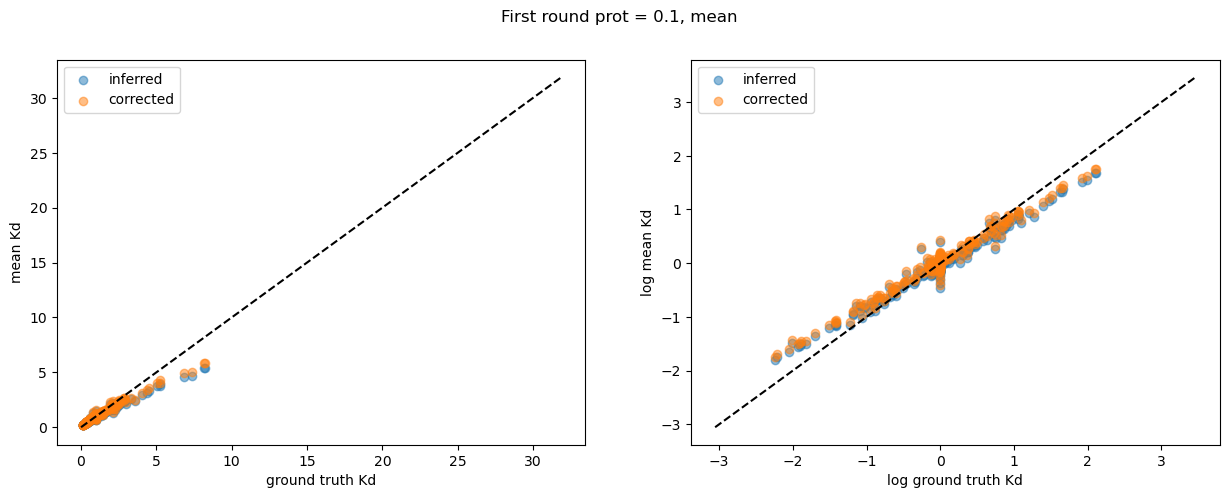

squared error for mean of inferred Kds and corrected Kds
0.162
0.116
difference between squared error for mean of inferred Kds and corrected Kds
0.046


In [98]:
comparison_plot(ground_truth, inferred_Kds_prot_01_01, inferred_Kds_prot_01_1, inferred_Kds_prot_01_10, corrected_Kds_prot_01_01, corrected_Kds_prot_01_1, corrected_Kds_prot_01_10, 'First round prot = 0.1')

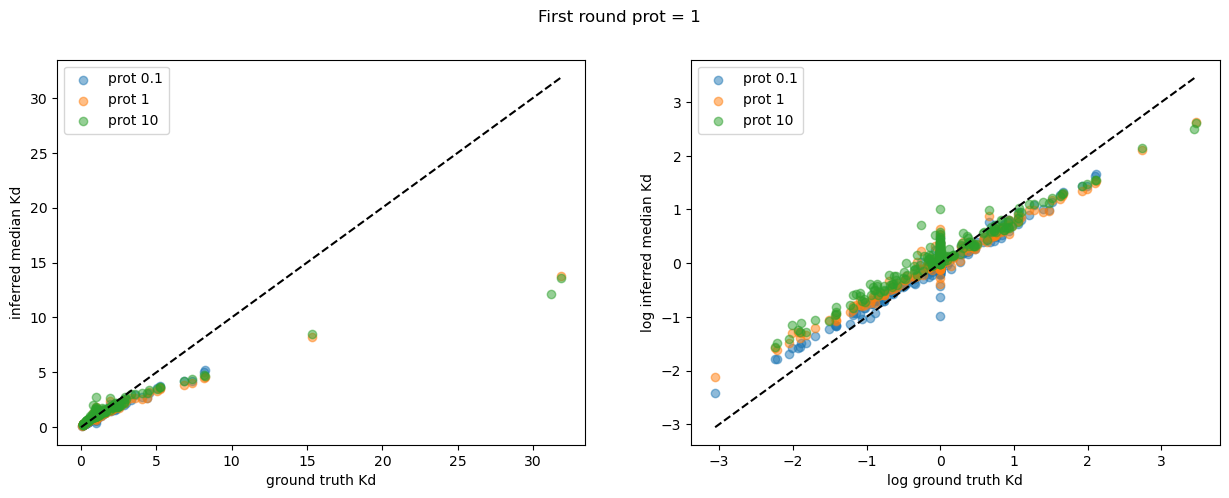

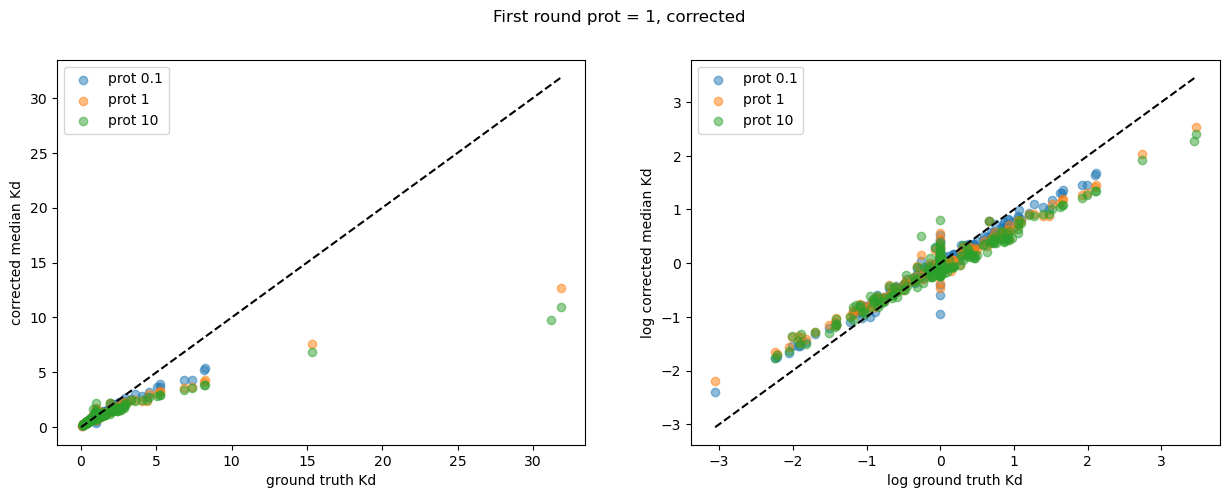

squared error for inferred Kds
0.205
1.521
2.73
squared error for corrected Kds
0.185
1.744
3.618
difference between squared error for inferred Kds and corrected Kds
0.02
-0.223
-0.887


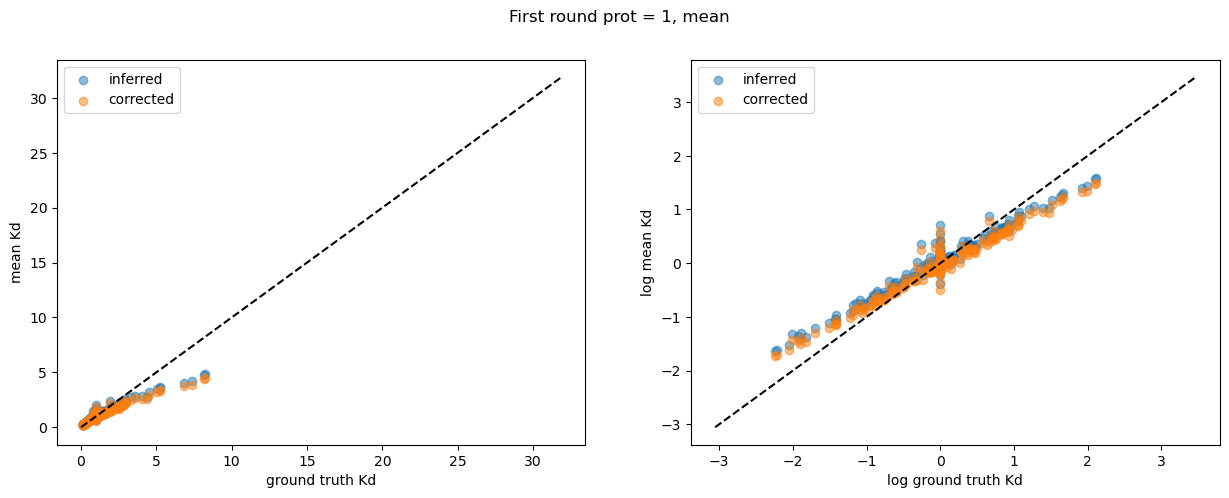

squared error for mean of inferred Kds and corrected Kds
0.224
0.287
difference between squared error for mean of inferred Kds and corrected Kds
-0.063


In [99]:
comparison_plot(ground_truth, inferred_Kds_prot_1_01, inferred_Kds_prot_1_1, inferred_Kds_prot_1_10, corrected_Kds_prot_1_01, corrected_Kds_prot_1_1, corrected_Kds_prot_1_10, 'First round prot = 1')

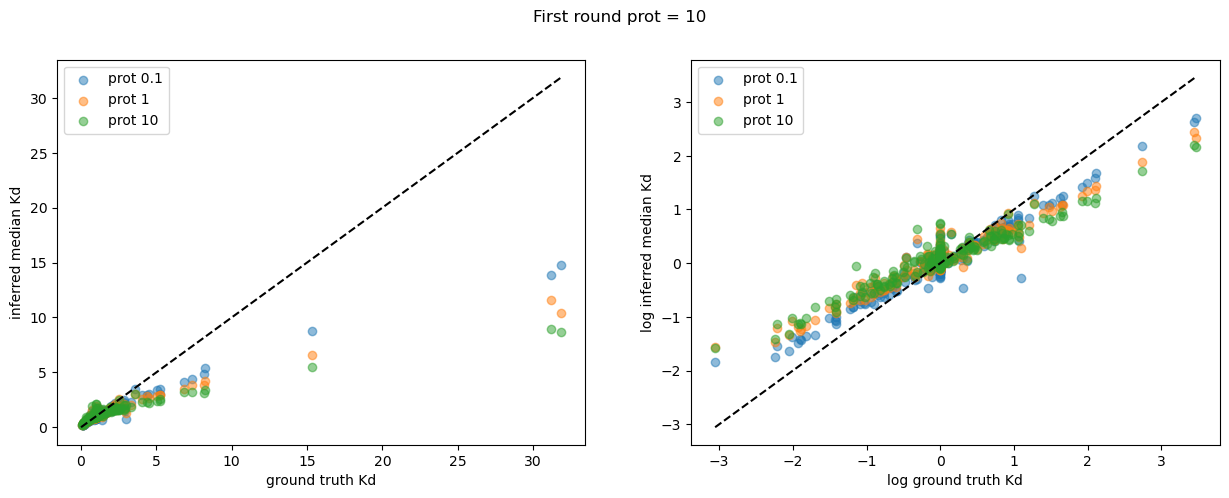

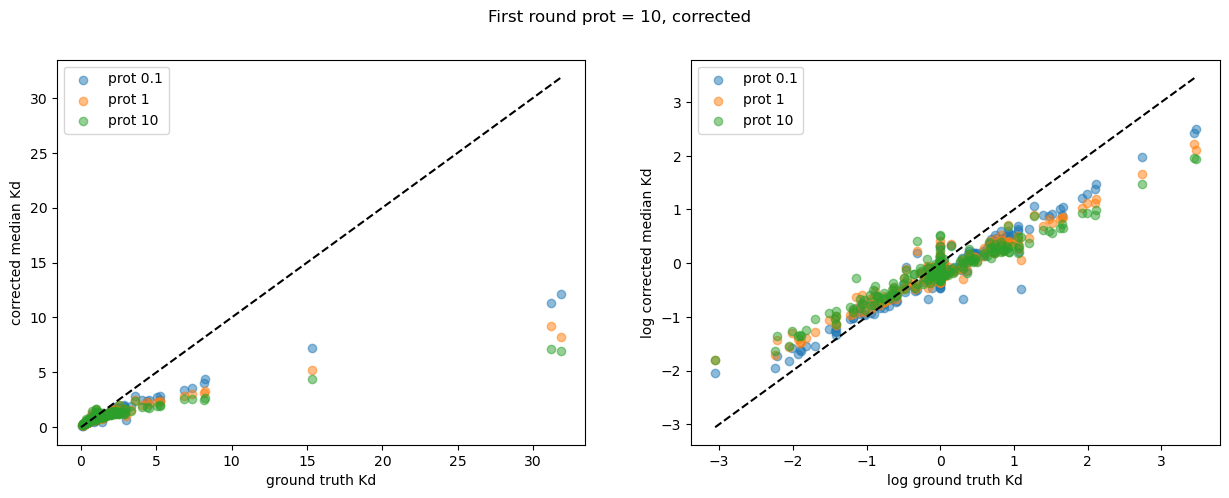

squared error for inferred Kds
2.349
3.43
4.248
squared error for corrected Kds
3.248
4.366
5.081
difference between squared error for inferred Kds and corrected Kds
-0.899
-0.936
-0.832


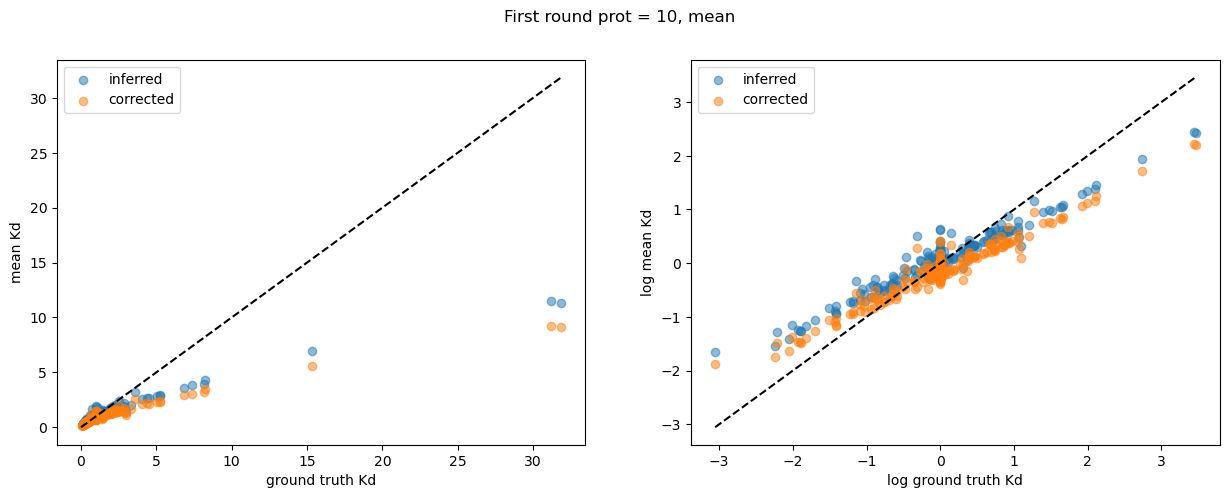

squared error for mean of inferred Kds and corrected Kds
3.287
4.191
difference between squared error for mean of inferred Kds and corrected Kds
-0.904


In [100]:
comparison_plot(ground_truth, inferred_Kds_prot_10_01, inferred_Kds_prot_10_1, inferred_Kds_prot_10_10, corrected_Kds_prot_10_01, corrected_Kds_prot_10_1, corrected_Kds_prot_10_10, 'First round prot = 10')

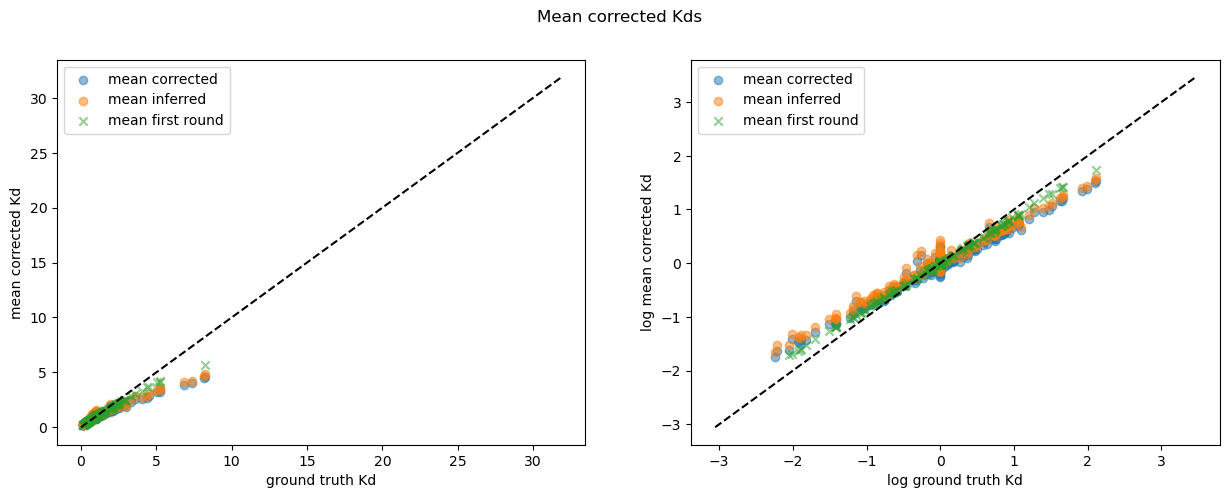

In [101]:
# take the mean of the corrected Kds
mean_corrected_Kds_prot_01 = np.mean([corrected_Kds_prot_01_01, corrected_Kds_prot_01_1, corrected_Kds_prot_01_10], axis=0)
mean_corrected_Kds_prot_1 = np.mean([corrected_Kds_prot_1_01, corrected_Kds_prot_1_1, corrected_Kds_prot_1_10], axis=0)
mean_corrected_Kds_prot_10 = np.mean([corrected_Kds_prot_10_01, corrected_Kds_prot_10_1, corrected_Kds_prot_10_10], axis=0)

# take the mean of the inferred Kds
mean_inferred_Kds_prot_01 = np.mean([inferred_Kds_prot_01_01, inferred_Kds_prot_01_1, inferred_Kds_prot_01_10], axis=0)
mean_inferred_Kds_prot_1 = np.mean([inferred_Kds_prot_1_01, inferred_Kds_prot_1_1, inferred_Kds_prot_1_10], axis=0)
mean_inferred_Kds_prot_10 = np.mean([inferred_Kds_prot_10_01, inferred_Kds_prot_10_1, inferred_Kds_prot_10_10], axis=0)

# take the mean of the first round inferred Kds
mean_first_round_Kds = np.mean([prot_01, prot_1, prot_10], axis=0)

# take the mean of all 3 protein concentrations
mean_corrected_Kds = np.mean([mean_corrected_Kds_prot_01, mean_corrected_Kds_prot_1, mean_corrected_Kds_prot_10], axis=0)
mean_inferred_Kds = np.mean([mean_inferred_Kds_prot_01, mean_inferred_Kds_prot_1, mean_inferred_Kds_prot_10], axis=0)

# plot the mean of the corrected Kds vs ground truth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot ground truth vs corrected median Kds of each protein concentration
ax1.scatter(ground_truth, mean_corrected_Kds, label='mean corrected', alpha=0.5)
# also plot inferred Kds mean
ax1.scatter(ground_truth, mean_inferred_Kds, label='mean inferred', alpha=0.5)
ax1.scatter(ground_truth, mean_first_round_Kds, label='mean first round', alpha=0.5, marker='x')
ax1.set_xlabel('ground truth Kd')
ax1.set_ylabel('mean corrected Kd')
ax1.legend()
x = np.linspace(0, np.max(ground_truth), 100)
y = x
ax1.plot(x, y, color='black', linestyle='--')

# plot log ground truth vs log corrected median Kds of each protein concentration
ax2.scatter(np.log(ground_truth), np.log(mean_corrected_Kds), label='mean corrected', alpha=0.5)
# also plot inferred Kds mean
ax2.scatter(np.log(ground_truth), np.log(mean_inferred_Kds), label='mean inferred', alpha=0.5)
ax2.scatter(np.log(ground_truth), np.log(mean_first_round_Kds), label='mean first round', alpha=0.5, marker='x')
ax2.set_xlabel('log ground truth Kd')
ax2.set_ylabel('log mean corrected Kd')
ax2.legend()
x = np.linspace(np.min(np.log(ground_truth)), np.max(np.log(ground_truth)), 100)
y = x
ax2.plot(x, y, color='black', linestyle='--')

# set overall title
fig.suptitle('Mean corrected Kds')

plt.show()

In [102]:
def correct_Kds_complete(path_inferred_kds : str, path_counts : str):
    # load unbound counts
    unbound_counts = np.loadtxt(path_counts+'8.txt', skiprows=1, dtype=int)
    # load bound counts
    bound_counts = np.loadtxt(path_counts+'7.txt', skiprows=1, dtype=int)
    counts = bound_counts + unbound_counts
    # remove first column (pos)
    counts = counts[:, 1:]
    # subtract 0.45 percent from all mutation columns
    counts[:, 1] = counts[:, 1] - counts[:, 1]*0.0045
    counts[:, 2] = counts[:, 2] - counts[:, 2]*0.0045
    counts[:, 3] = counts[:, 3] - counts[:, 3]*0.0045
    # compute proportion of unbound counts
    counts = counts / counts.sum(axis=1)[:, None]
    # remove first column (wildtype unbound counts)
    counts = counts[:, 1:]

    # load inferred Kds
    df = pd.read_csv(path_inferred_kds, sep='\t')
    # replace nan with 1
    # df = df.fillna(1)

    median_mut_C = df['median mut C'].values
    median_mut_G = df['median mut G'].values
    median_mut_U = df['median mut U'].values

    # stack median_mut_C, median_mut_G, median_mut_U as columns
    median_Kds = np.vstack((median_mut_C, median_mut_G, median_mut_U)).T
    
    # initialize corrected_Kds
    corrected_Kds = np.zeros(median_Kds.shape)

    # formula is x_i = np.exp((np.log(y_i) + p_1*np.log(y_1/y_i) + p_2*np.log(y_2/y_i) + p_3*np.log(y_3/y_i))/(1-p_1-p_2-p_3))
    # y_i is mutation of interest, y_1, y_2, y_3 are all possible mutations at that position

    # loop through each row of median_Kds
    for i in range(median_Kds.shape[0]):
        # loop through each column of median_Kds
        for j in range(median_Kds.shape[1]):
            # compute corrected_Kds[i, j]
            corrected_Kds[i, j] = np.exp((np.log(median_Kds[i, j]) + counts[i, 0]*np.log(median_Kds[i, 0]/median_Kds[i, j]) + counts[i, 1]*np.log(median_Kds[i, 1]/median_Kds[i, j]) + counts[i, 2]*np.log(median_Kds[i, 2]/median_Kds[i, j]))/(1-counts[i, 0]-counts[i, 1]-counts[i, 2]))

    # stack rows of corrected_Kds to get a 1D array
    corrected_Kds = corrected_Kds.flatten()


    return corrected_Kds

In [103]:
complete_corrected_Kds_prot_01_01 = correct_Kds_complete(data_path + '/secondFromProt0.1/prot0.1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt0.1/prot0.1/1d/')
complete_corrected_Kds_prot_01_1 = correct_Kds_complete(data_path + '/secondFromProt0.1/prot1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt0.1/prot1/1d/')
complete_corrected_Kds_prot_01_10 = correct_Kds_complete(data_path + '/secondFromProt0.1/prot10/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt0.1/prot10/1d/')

complete_corrected_Kds_prot_1_01 = correct_Kds_complete(data_path + '/secondFromProt1/prot0.1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt1/prot0.1/1d/')
complete_corrected_Kds_prot_1_1 = correct_Kds_complete(data_path + '/secondFromProt1/prot1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt1/prot1/1d/')
complete_corrected_Kds_prot_1_10 = correct_Kds_complete(data_path + '/secondFromProt1/prot10/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt1/prot10/1d/')

complete_corrected_Kds_prot_10_01 = correct_Kds_complete(data_path + '/secondFromProt10/prot0.1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt10/prot0.1/1d/')
complete_corrected_Kds_prot_10_1 = correct_Kds_complete(data_path + '/secondFromProt10/prot1/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt10/prot1/1d/')
complete_corrected_Kds_prot_10_10 = correct_Kds_complete(data_path + '/secondFromProt10/prot10/results/PositionWiseKdEstimates.csv', data_path + '/secondFromProt10/prot10/1d/')

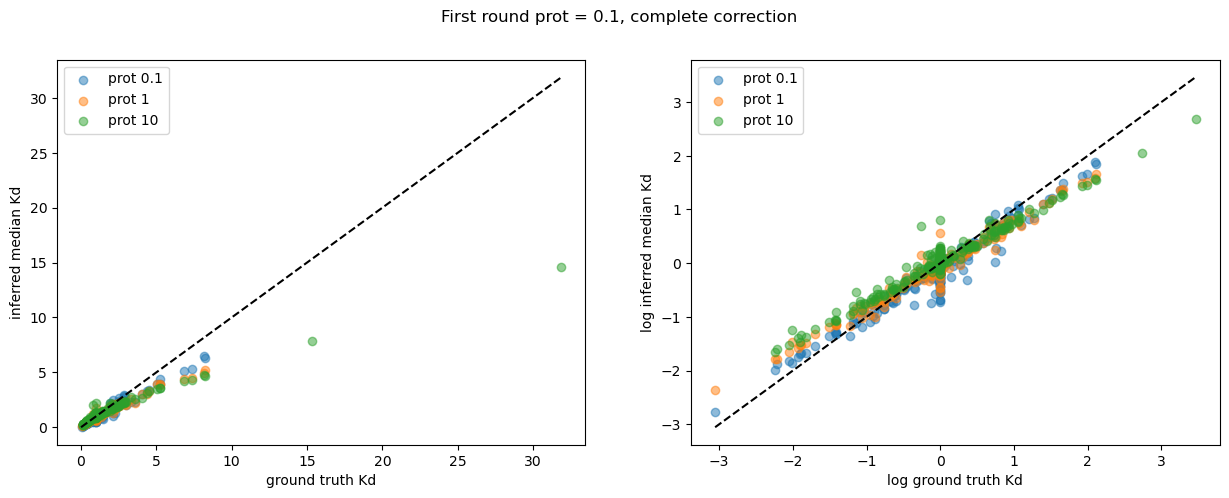

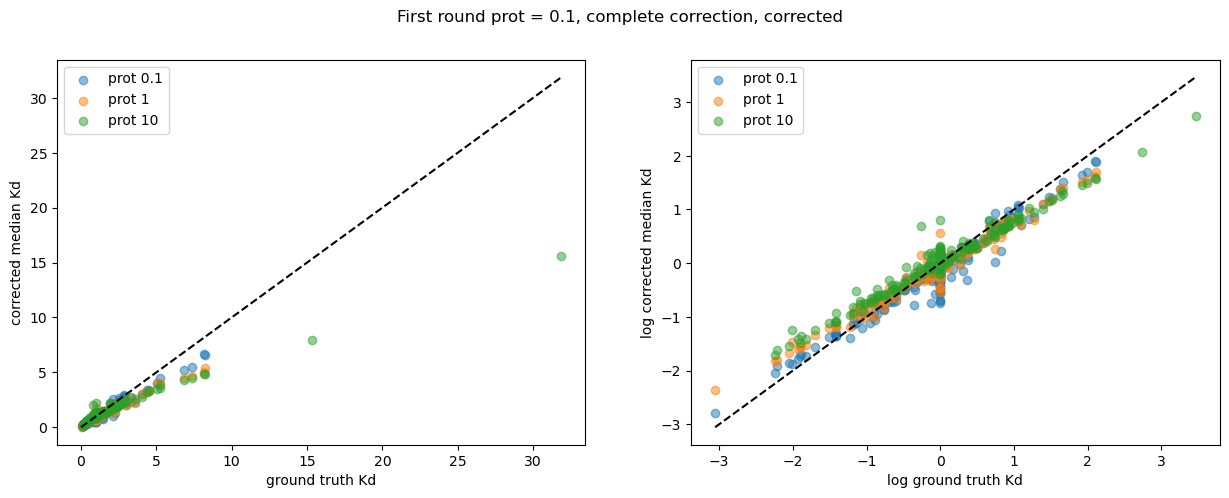

squared error for inferred Kds
0.121
0.189
1.42
squared error for corrected Kds
0.103
0.17
1.296
difference between squared error for inferred Kds and corrected Kds
0.018
0.019
0.124


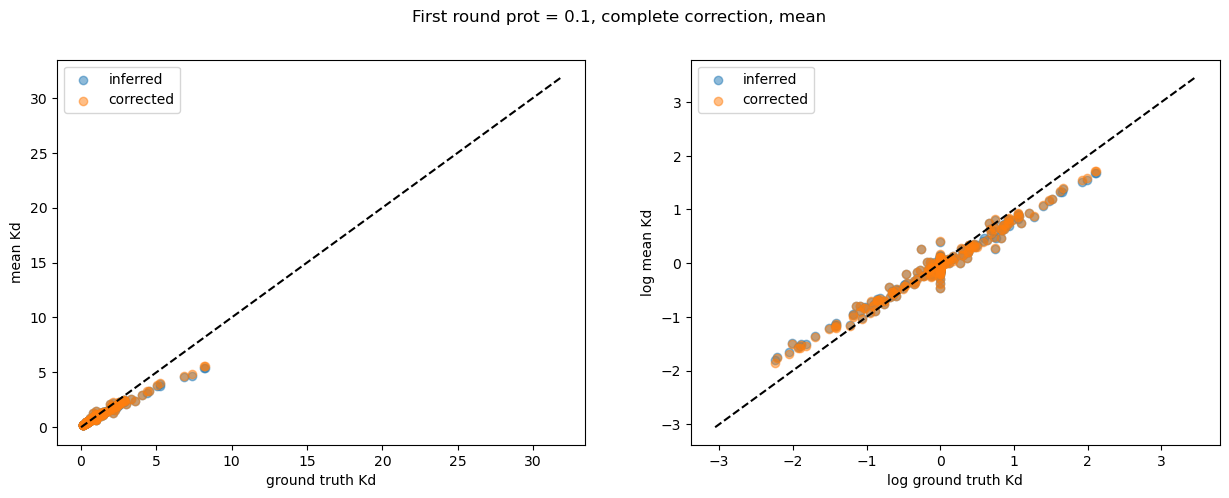

squared error for mean of inferred Kds and corrected Kds
0.162
0.143
difference between squared error for mean of inferred Kds and corrected Kds
0.019


In [104]:
comparison_plot(ground_truth, inferred_Kds_prot_01_01, inferred_Kds_prot_01_1, inferred_Kds_prot_01_10, complete_corrected_Kds_prot_01_01, complete_corrected_Kds_prot_01_1, complete_corrected_Kds_prot_01_10, 'First round prot = 0.1, complete correction')

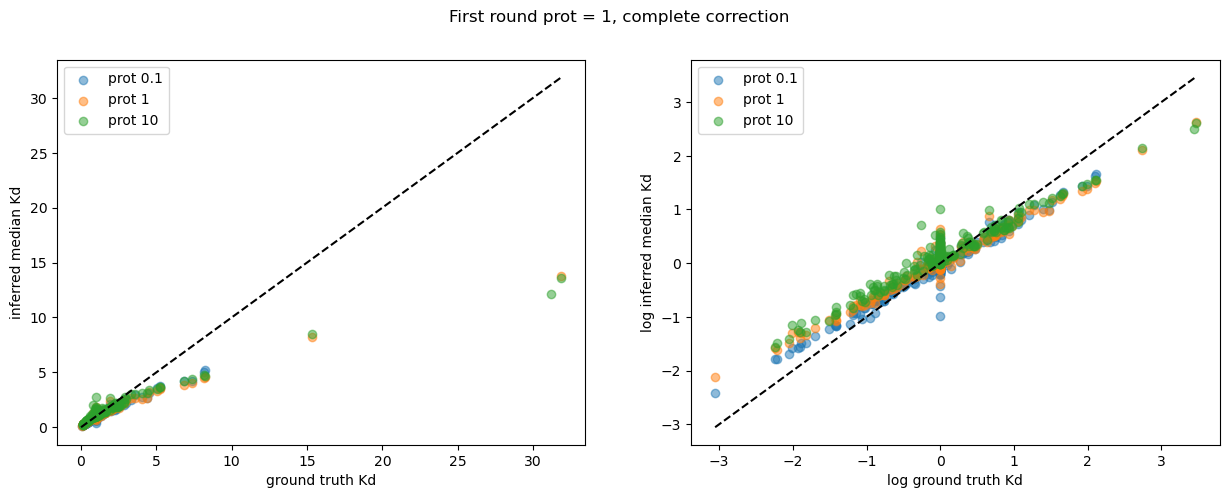

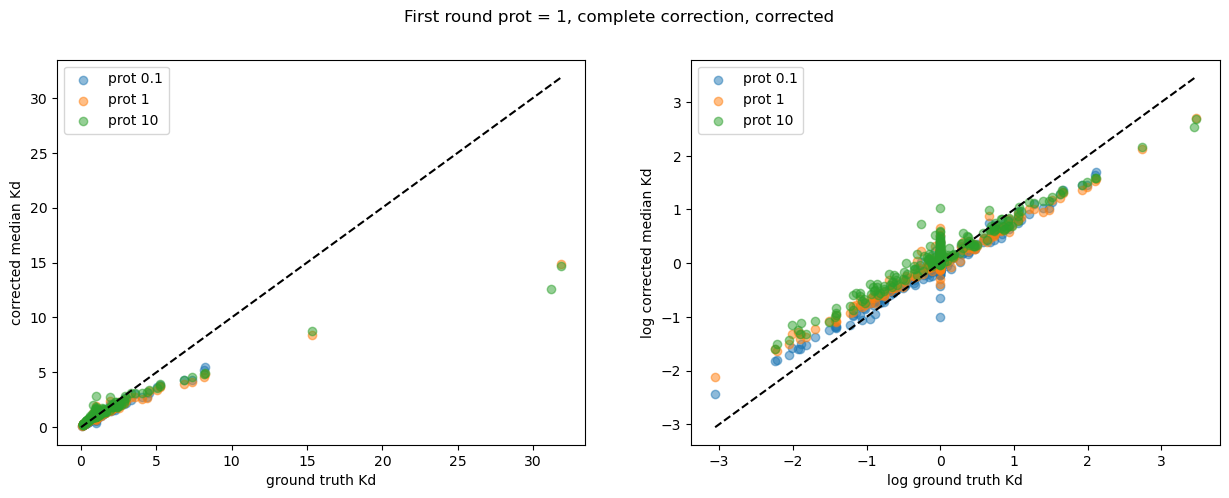

squared error for inferred Kds
0.205
1.521
2.73
squared error for corrected Kds
0.183
1.371
2.527
difference between squared error for inferred Kds and corrected Kds
0.023
0.15
0.204


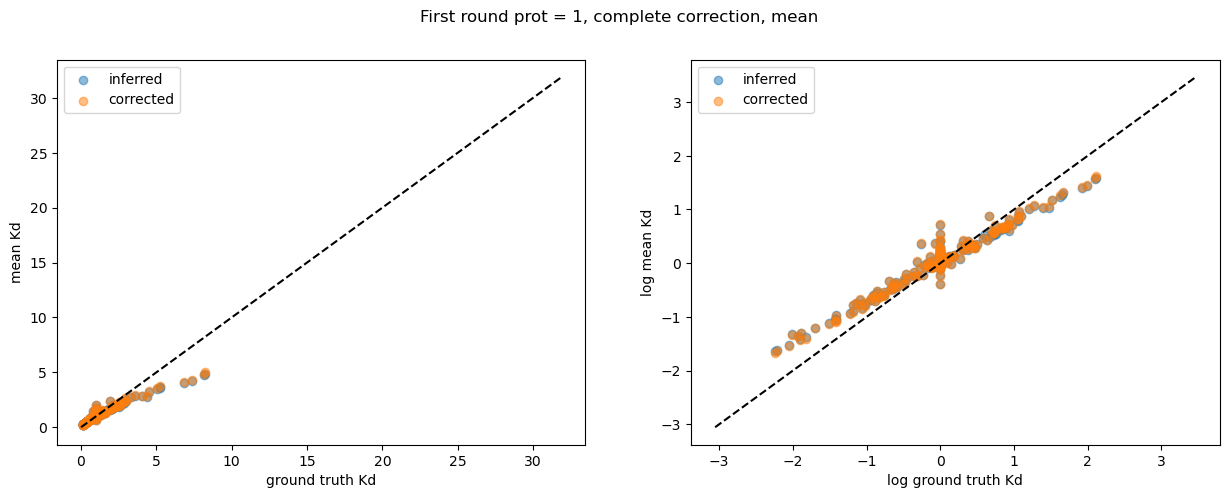

squared error for mean of inferred Kds and corrected Kds
0.224
0.202
difference between squared error for mean of inferred Kds and corrected Kds
0.022


In [105]:
comparison_plot(ground_truth, inferred_Kds_prot_1_01, inferred_Kds_prot_1_1, inferred_Kds_prot_1_10, complete_corrected_Kds_prot_1_01, complete_corrected_Kds_prot_1_1, complete_corrected_Kds_prot_1_10, 'First round prot = 1, complete correction')

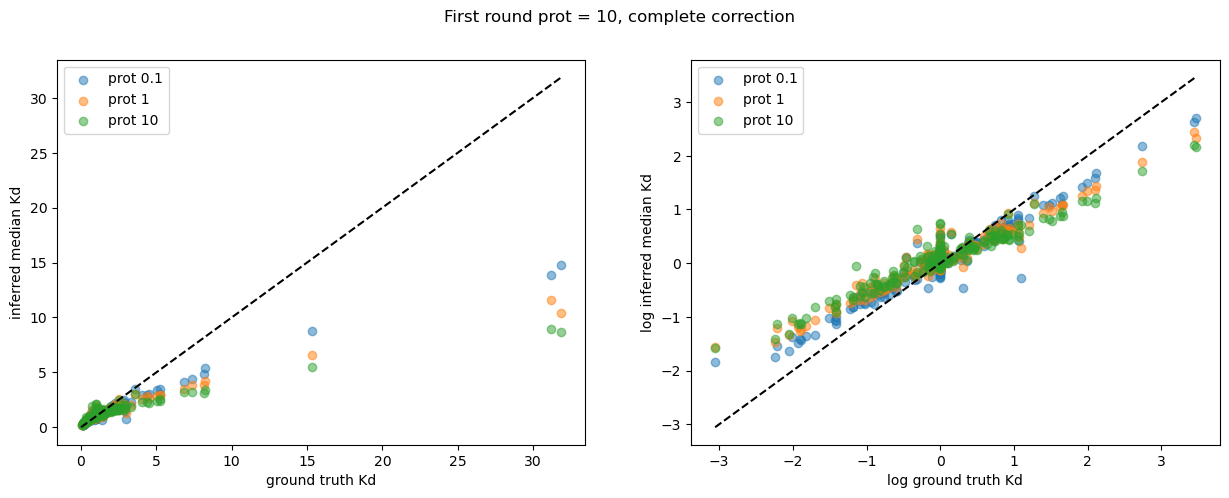

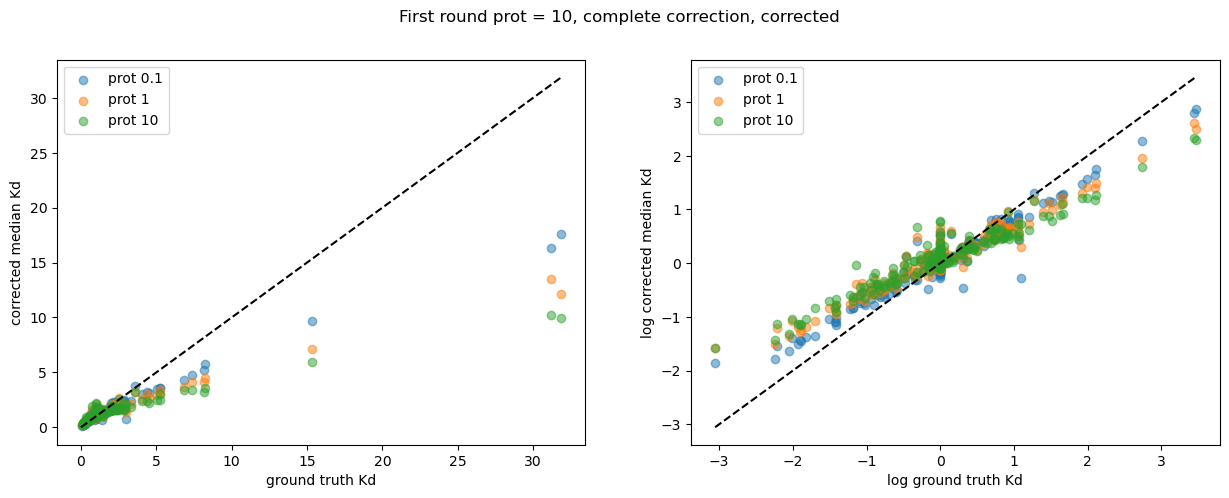

squared error for inferred Kds
2.349
3.43
4.248
squared error for corrected Kds
1.715
2.883
3.801
difference between squared error for inferred Kds and corrected Kds
0.634
0.547
0.447


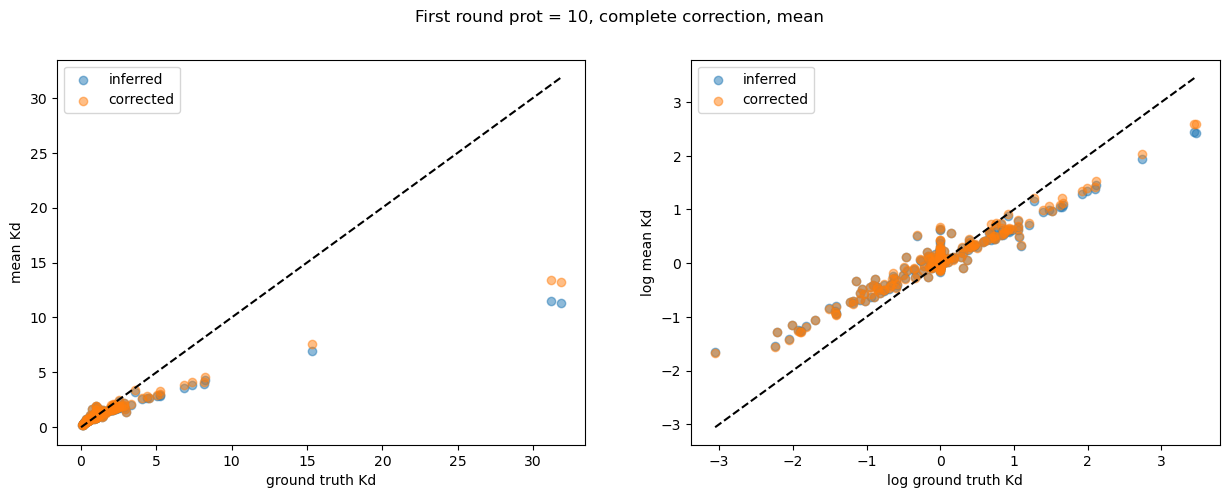

squared error for mean of inferred Kds and corrected Kds
3.287
2.721
difference between squared error for mean of inferred Kds and corrected Kds
0.566


In [106]:
comparison_plot(ground_truth, inferred_Kds_prot_10_01, inferred_Kds_prot_10_1, inferred_Kds_prot_10_10, complete_corrected_Kds_prot_10_01, complete_corrected_Kds_prot_10_1, complete_corrected_Kds_prot_10_10, 'First round prot = 10, complete correction')

In [107]:
def correct_Kds_first_round(path_inferred_kds : str, path_counts : str):
    # load unbound counts
    unbound_counts = np.loadtxt(path_counts+'4.txt', skiprows=1, dtype=int)
    # load bound counts
    bound_counts = np.loadtxt(path_counts+'3.txt', skiprows=1, dtype=int)
    counts = bound_counts + unbound_counts
    # remove first column (pos)
    counts = counts[:, 1:]
    # subtract 0.45 percent from all mutation columns
    counts[:, 1] = counts[:, 1] - counts[:, 1]*0.0045
    counts[:, 2] = counts[:, 2] - counts[:, 2]*0.0045
    counts[:, 3] = counts[:, 3] - counts[:, 3]*0.0045
    # compute proportion of unbound counts
    counts = counts / counts.sum(axis=1)[:, None]
    # remove first column (wildtype unbound counts)
    counts = counts[:, 1:]

    # load inferred Kds
    df = pd.read_csv(path_inferred_kds, sep='\t')
    # replace nan with 1
    # df = df.fillna(1)

    median_mut_C = df['median mut C'].values
    median_mut_G = df['median mut G'].values
    median_mut_U = df['median mut U'].values

    # stack median_mut_C, median_mut_G, median_mut_U as columns
    median_Kds = np.vstack((median_mut_C, median_mut_G, median_mut_U)).T
    
    # initialize corrected_Kds
    corrected_Kds = np.zeros(median_Kds.shape)

    # formula is x_i = np.exp((np.log(y_i) + p_1*np.log(y_1/y_i) + p_2*np.log(y_2/y_i) + p_3*np.log(y_3/y_i))/(1-p_1-p_2-p_3))
    # y_i is mutation of interest, y_1, y_2, y_3 are all possible mutations at that position

    # loop through each row of median_Kds
    for i in range(median_Kds.shape[0]):
        # loop through each column of median_Kds
        for j in range(median_Kds.shape[1]):
            # compute corrected_Kds[i, j]
            corrected_Kds[i, j] = np.exp((np.log(median_Kds[i, j]) + counts[i, 0]*np.log(median_Kds[i, 0]/median_Kds[i, j]) + counts[i, 1]*np.log(median_Kds[i, 1]/median_Kds[i, j]) + counts[i, 2]*np.log(median_Kds[i, 2]/median_Kds[i, j]))/(1-counts[i, 0]-counts[i, 1]-counts[i, 2]))

    # stack rows of corrected_Kds to get a 1D array
    corrected_Kds = corrected_Kds.flatten()


    return corrected_Kds

In [108]:
corrected_Kds_prot_01 = correct_Kds_first_round(data_path + '/prot0.1/results/PositionWiseKdEstimates.csv', data_path + '/prot0.1/1d/')
corrected_Kds_prot_1 = correct_Kds_first_round(data_path + '/prot1/results/PositionWiseKdEstimates.csv', data_path + '/prot1/1d/')
corrected_Kds_prot_10 = correct_Kds_first_round(data_path + '/prot10/results/PositionWiseKdEstimates.csv', data_path + '/prot10/1d/')

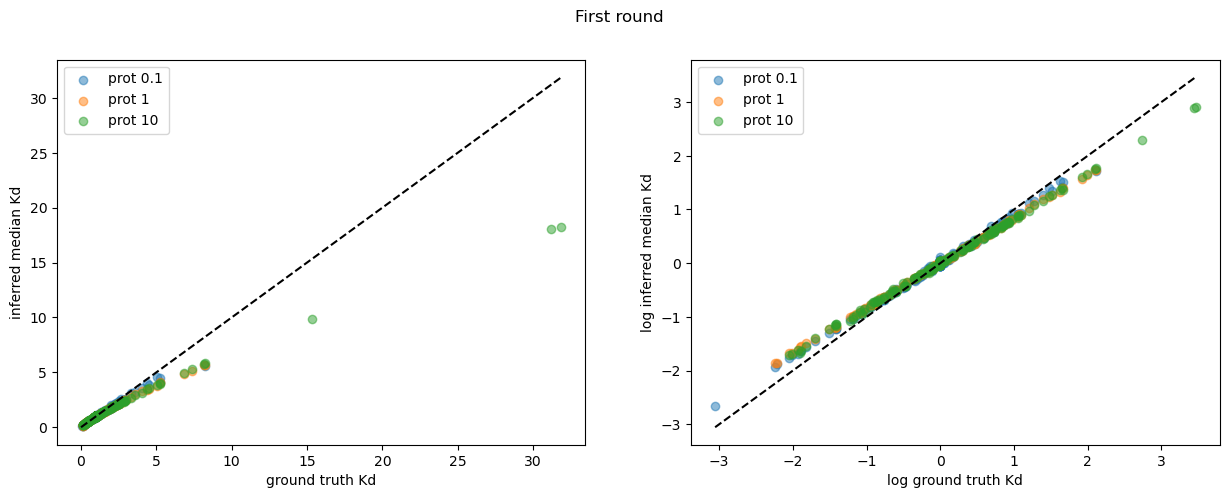

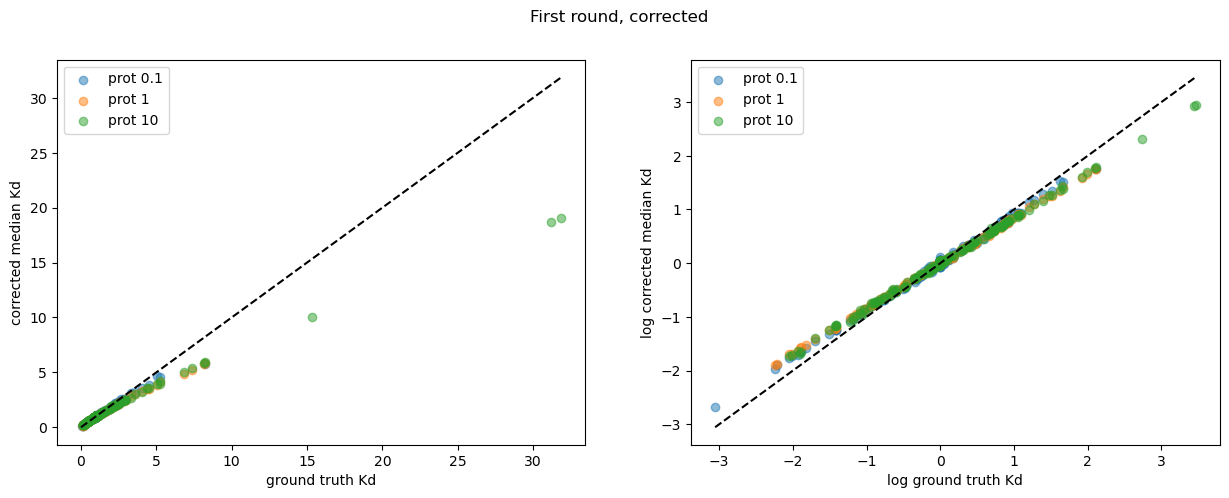

squared error for inferred Kds
0.042
0.11
1.411
squared error for corrected Kds
0.035
0.1
1.293
difference between squared error for inferred Kds and corrected Kds
0.007
0.011
0.118


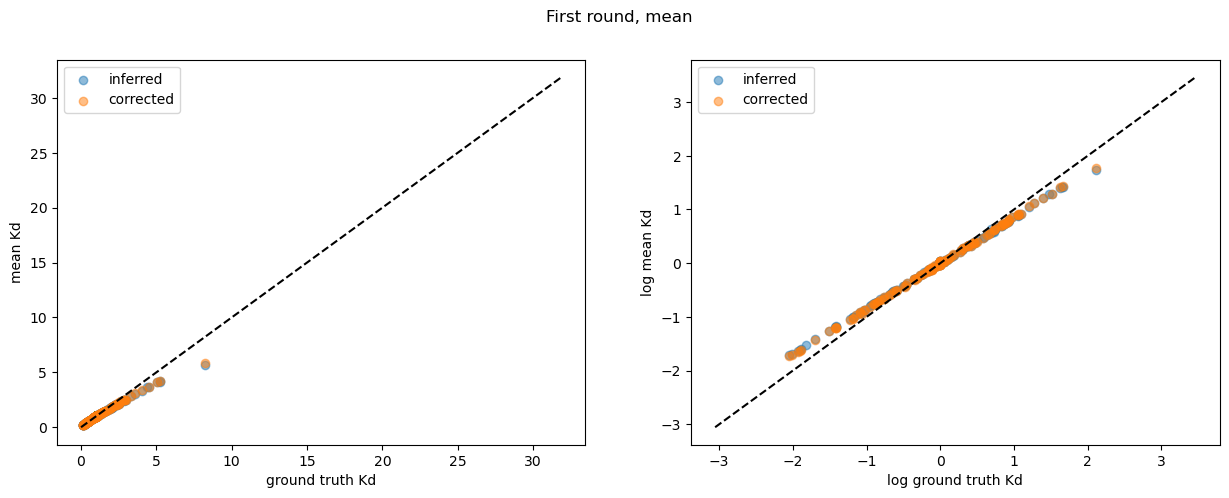

squared error for mean of inferred Kds and corrected Kds
0.052
0.043
difference between squared error for mean of inferred Kds and corrected Kds
0.009


In [109]:
comparison_plot(ground_truth, prot_01, prot_1, prot_10, corrected_Kds_prot_01, corrected_Kds_prot_1, corrected_Kds_prot_10, 'First round')